In [5]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)



1.15.2


In [4]:
!pip uninstall keras
!pip install keras==2.2.5


Found existing installation: Keras 2.3.1
Uninstalling Keras-2.3.1:
  Would remove:
    /tensorflow-1.15.2/python3.7/Keras-2.3.1.dist-info/*
    /tensorflow-1.15.2/python3.7/docs/*
    /tensorflow-1.15.2/python3.7/keras/*
Proceed (y/n)? y
  Successfully uninstalled Keras-2.3.1


In [6]:
import tensorflow
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Dropout, Flatten
from keras.optimizers import Adam
########################################



Using TensorFlow backend.


In [ ]:
!unzip ./images.zip

In [7]:
path='images'
images=[]
classNo=[]
testRatio=0.2
valRatio=0.2
imgDimension=(32,32,3)

#########################################

myList=os.listdir(path)

numOfClasses=len(myList)

# print(numOfClasses)

print("Importing Classes..........")
#Le immagini vengono ridimensionate e poi caricate all'interno della variabile curImg
for x in range(0, numOfClasses):
	myPicList=os.listdir(path+"/"+str(x))
	# myData/0/img.jpg
	for y in myPicList:
		curImg=cv2.imread(path+"/"+str(x)+"/"+y)
		curImg=cv2.resize(curImg,(imgDimension[0],imgDimension[1]))
		images.append(curImg)
		classNo.append(x)
	print(x)
#immagini convertite in un array numpy
images=np.array(images)
classNo=np.array(classNo)
print(len(images))
print(len(classNo))

#images contiene tutte le immagini
#classNo tiene traccia delle immagini all'interno di ciascuna immagine




Importing Classes..........
0
1
1002
1002


2


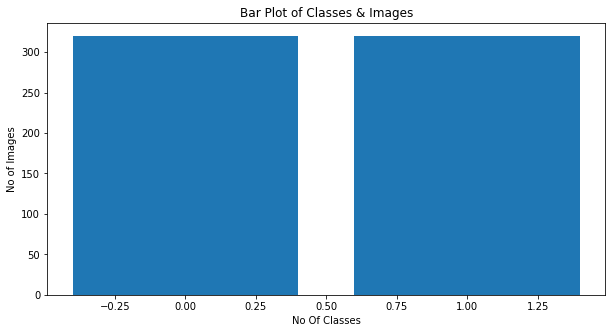

640
32
32





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)         

In [8]:
#########Spliting The Data###########

x_train, x_test, y_train, y_test=train_test_split(images, classNo, test_size=testRatio)
x_train, x_validation, y_train, y_validation=train_test_split(x_train, y_train, test_size=valRatio)

## print(x_train.shape)

numOfSample=[]

for x in range(0,numOfClasses):
	numOfSample.append(len(np.where(y_train==x)[0]))

print(len(numOfSample))
plt.figure(figsize=(10,5))
plt.bar(range(0, numOfClasses),numOfSample)
plt.title("Bar Plot of Classes & Images")
plt.xlabel("No Of Classes")
plt.ylabel("No of Images")
plt.show()


def preprocessing(img):
	# img=np.astype("uint8")
	img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	img=cv2.equalizeHist(img)
	img=img/255
	return img


x_train=np.array(list(map(preprocessing, x_train))) #Effettua il "preprocessing" di ogni immagine all'interno di x_train
x_test=np.array(list(map(preprocessing, x_test))) #Effettua il "preprocessing" di ogni immagine all'interno di x_test
x_validation=np.array(list(map(preprocessing, x_validation))) #Effettua il "preprocessing" di ogni immagine all'interno di x_validation



print(x_train.shape[0])
print(x_train.shape[1])
print(x_train.shape[2])



x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2],1)
x_test=x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2],1)
x_validation=x_validation.reshape(x_validation.shape[0], x_validation.shape[1], x_validation.shape[2],1)


dataGen=ImageDataGenerator(
	width_shift_range=0.1,
	height_shift_range=0.1,
	zoom_range=0.2,
	shear_range=0.1,
	rotation_range=10)

dataGen.fit(x_train)

y_train=to_categorical(y_train, numOfClasses)
y_test=to_categorical(y_test, numOfClasses)
y_validation=to_categorical(y_validation, numOfClasses)

def myModel():
	sizeOfFilter1=(3,3)
	sizeOfFilter2=(3,3)
	sizeOfPool=(2,2)

	model=Sequential()
	model.add((Conv2D(32, sizeOfFilter1, input_shape=(imgDimension[0],imgDimension[1],1),activation='relu')))
	model.add((Conv2D(32, sizeOfFilter1,activation='relu')))
	model.add(MaxPooling2D(pool_size=sizeOfPool))

	model.add((Conv2D(64, sizeOfFilter2,activation='relu')))
	model.add((Conv2D(64, sizeOfFilter2,activation='relu')))
	model.add(MaxPooling2D(pool_size=sizeOfPool))
	model.add(Dropout(0.5))


	model.add(Flatten())
	model.add(Dense(64, activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(numOfClasses, activation='softmax'))
	model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
	return model

model=myModel()
print(model.summary())
s = len(x_train)//50

history=model.fit_generator(dataGen.flow(x_train, y_train,batch_size=50),
	steps_per_epoch= s,
	epochs=50,
	validation_data=(x_validation,y_validation),
	shuffle=1)

model.save("MyTrainingModel.h5")